# Imports

In [1]:
import os
import shutil
import copy
import matplotlib.pyplot as plt

from molgroups.support import molstat
from molgroups.infotheory import entropy

print(os.getcwd())

# always use the same testdata
shutil.copyfile('./bu/sim0.dat', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/sim1.dat', os.getcwd()+'/sim1.dat')
#shutil.copyfile('./bu/sim2.dat', os.getcwd()+'/sim2.dat')

RunOptimization=True

/Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_sequential_execution/SANS/SphereSilica_TwoDatasets_SolventSLD_CountingTime_GPCam


# Create Short Example Fit

- The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [2]:
%%writefile sanssilica.py
import numpy

from bumps.names import *
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
data1 = load_data('sim1.dat')
#data2 = load_data('sim2.dat')

#setattr(data, 'qmin', 0.01)
#setattr(data, 'qmax', 10.0)

# DEFINE THE MODEL
kernel = load_model('sphere')

pars0 = dict(scale=0.002, background=0.15, sld=3.0, sld_solvent=2.4, radius=60.0, radius_pd=0.3)
pars1 = dict(scale=0.002, background=0.15, sld=3.0, sld_solvent=3.4, radius=60.0, radius_pd=0.3)
#pars2 = dict(scale=0.002, background=0.15, sld=3.0, sld_solvent=4.4, radius=60.0, radius_pd=0.3)

model0 = Model(kernel, **pars0)
model1 = Model(kernel, **pars1)
#model2 = Model(kernel, **pars2)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)

background0 = Parameter(name='background0', value=0.4).range(0.01, 0.8)
background1 = Parameter(name='background1', value=0.4).range(0.01, 0.8)
#background2 = Parameter(name='background2', value=0.4).range(0.01, 0.8)
sld_solvent0 = Parameter(name='sld_solvent0', value=2.0).range(-0.56, 6.4)
sld_solvent1 = Parameter(name='sld_solvent1', value=2.0).range(-0.56, 6.4)
#sld_solvent2 = Parameter(name='sld_solvent2', value=2.0).range(-0.56, 6.4)

model0.scale.range(0.0001, 0.05)
model0.background = background0
model0.sld.range(1, 4)
model0.sld_solvent = sld_solvent0
model0.radius.range(40., 120.)
model0.radius_pd.range(0.05, 0.7)

model1.scale = model0.scale
model1.background = background1
model1.sld = model0.sld
model1.sld_solvent = sld_solvent1
model1.radius = model0.radius
model1.radius_pd=model0.radius_pd

#model2.scale = model0.scale
#model2.background = background2
#model2.sld = model0.sld
#model2.sld_solvent = sld_solvent2
#model2.radius = model0.radius
#model2.radius_pd = model0.radius_pd


M0 = Experiment(data=data0, model=model0)
M1 = Experiment(data=data1, model=model1)
#M2 = Experiment(data=data2, model=model2)

problem = MultiFitProblem([M0, M1])
#problem = MultiFitProblem([M0, M1, M2])

Overwriting sanssilica.py


# Variables

In [3]:
#Example is from https://github.com/SasView/sasmodels/tree/master/example

store = "T"
setupdir = os.getcwd()
runfile = "sanssilica"
fitsource = "SASView"

# remove store directory if it already exists, since we do not want to reload here
if os.path.isdir(os.path.join(setupdir, store)):
    shutil.rmtree(os.path.join(setupdir, store))

burn=5000
steps=100


# Setup Example Fit

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/information_theory/entropy_gridsearch_sequential_execution/SANS/SphereSilica_TwoDatasets_SolventSLD_CountingTime_GPCam/T/sanssilica.py
No state to reload.


# steps: 100, # draws: 8000
step 1 cost 6713.125(19)
                             background0 .|........   0.153076 in (0.01,0.8)
                                  radius .......|..    101.385 in (40,120)
                               radius_pd .....|....   0.431366 in (0.05,0.7)
                                   scale .......|..  0.0369931 in (0.0001,0.05)
                                     sld .......|..    3.38858 in (1,4)
                            sld_solvent0 .....|....    2.98718 in (-0.56,6.4)
                             background1 ...|......   0.271517 in (0.01,0.8)
                            sld_solvent1 .....|....     2.9576 in (-0.56,6.4)
step 31 cost 237.905(19)
step 62 cost 55.977(19)
step 93 cost 27.066(19)
step 124 cost 19.954(19)
step 155 cost 18.934(19)
step 187 cost 18.813(19)
step 219 cost 17.974(19)
step 251 cost 17.632(19)
step 283 cost 17.632(19)
step 315 cost 17.490(19)
step 346 cost 17.467(19)
step 376 cost 17.397(19)
step 406 cost 17.303(19)
step 436 c

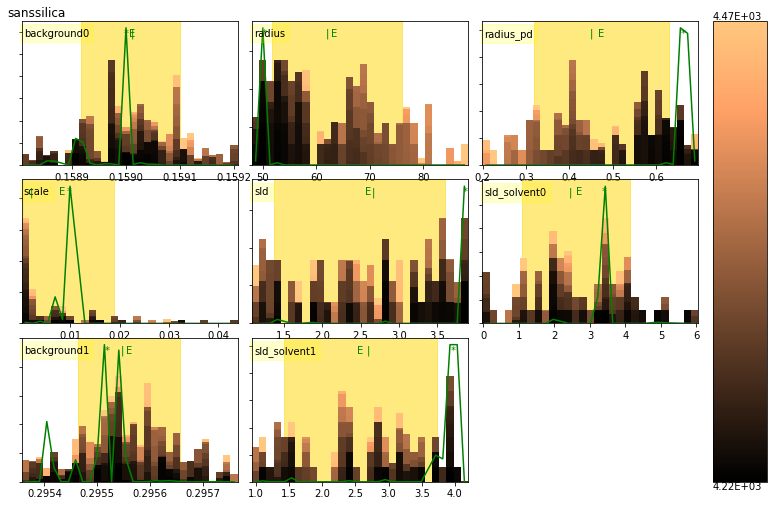

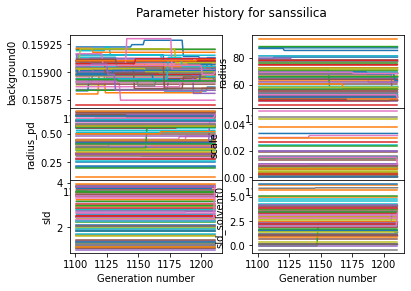

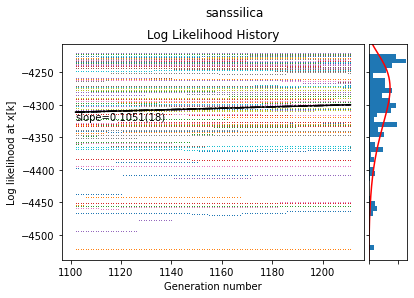

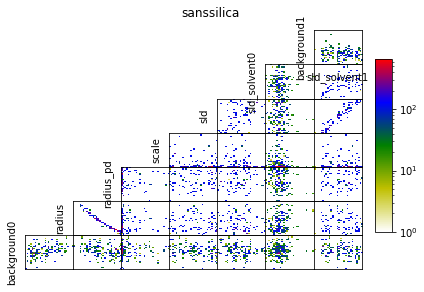

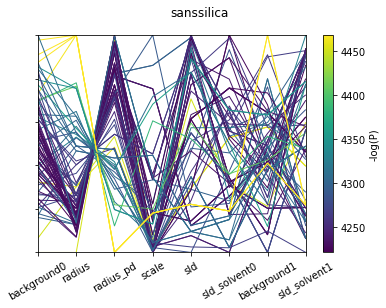

<Figure size 432x288 with 0 Axes>

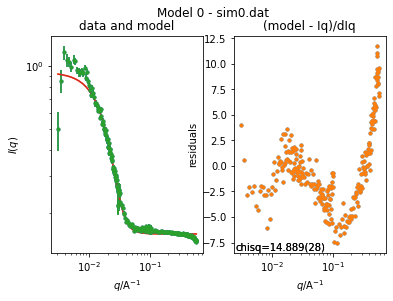

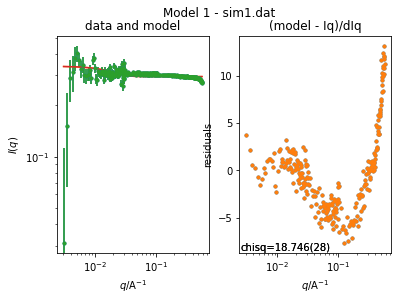

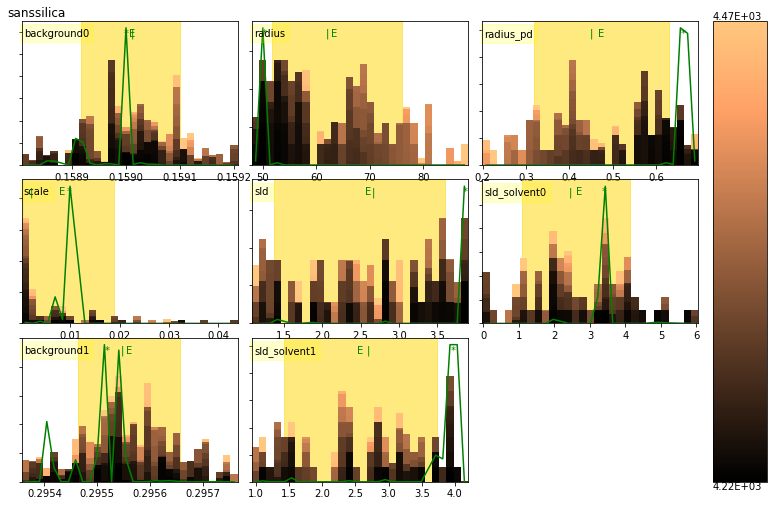

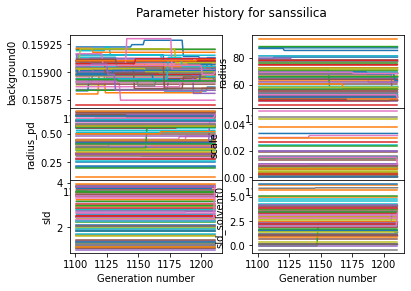

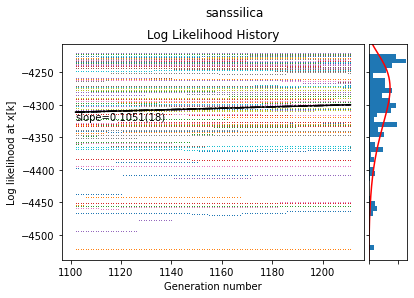

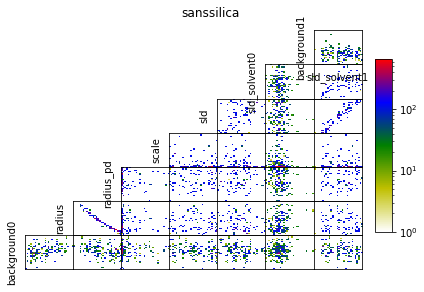

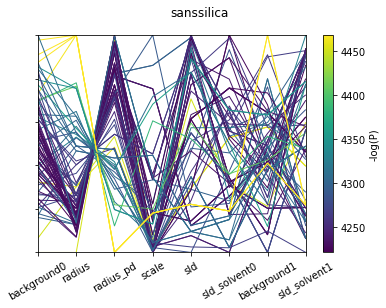

In [5]:
fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

# Single Dataset Simulation

In [6]:
text = [
    'background0 0.159031',
    'background1 0.295424',
    'sld_solvent0 3.090',
    'sld_solvent1 0.988',
    'scale 0.0007',
    'sld  1.355',
    'radius  49.67',
    'radius_pd 0.674',
    ]

f=open('simpar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

Overwriting simpar.dat


In [7]:
# buffer is not subtracted but treated as a fitting parameter
sb = 0.0
configuration_dataset1 = [{'lambda': 6.0,
                            "sample_detector_distance": 100,
                            'source_sample_distance': 387.6,
                            'source_aperture_radius':5.08*0.5,
                            'sample_aperture_radius':1.27*0.5,
                            "beamstop_diameter": 10.16,
                            "neutron_flux": 9e5,
                            'time': 1200,
                            'beam_center_x': 25,
                            "dlambda_lambda":0.136,
                            "differential_cross_section_buffer": sb,
                            "cuvette_thickness": 0.1},
                          {'lambda': 6.0,
                           "sample_detector_distance": 400,
                           'source_sample_distance': 850.05,
                           'source_aperture_radius':5.08*0.5,
                           'sample_aperture_radius':1.27*0.5,
                           "beamstop_diameter": 10.16,
                           "neutron_flux": 2e5,
                           'time': 2400,
                           "dlambda_lambda":0.136,
                           "differential_cross_section_buffer": sb,
                           "cuvette_thickness": 0.1},
                         {'lambda': 6.0,
                          "sample_detector_distance": 1300,
                          'source_sample_distance': 1467,
                          'source_aperture_radius':5.08*0.5,
                          'sample_aperture_radius':1.27*0.5,
                          "dlambda_lambda":0.136,
                          "beamstop_diameter": 7.62,
                          "neutron_flux": 8e4,
                          'time': 3600,
                          "differential_cross_section_buffer": sb,
                          "cuvette_thickness": 0.1}]

configuration = [configuration_dataset1, copy.deepcopy(configuration_dataset1)]
fitobj.fnSimulateData(basefilename='sim.dat', liConfigurations=configuration, qmin=0.001, qmax=0.8, t_total=None)

            par      value
0   background0   0.159031
1   background1   0.295424
2  sld_solvent0   3.090000
3  sld_solvent1   0.988000
4         scale   0.000700
5           sld   1.355000
6        radius  49.670000
7     radius_pd   0.674000
[[{'lambda': 6.0, 'sample_detector_distance': 100, 'source_sample_distance': 387.6, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 900000.0, 'time': 1200, 'beam_center_x': 25, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.0, 'cuvette_thickness': 0.1}, {'lambda': 6.0, 'sample_detector_distance': 400, 'source_sample_distance': 850.05, 'source_aperture_radius': 2.54, 'sample_aperture_radius': 0.635, 'beamstop_diameter': 10.16, 'neutron_flux': 200000.0, 'time': 2400, 'dlambda_lambda': 0.136, 'differential_cross_section_buffer': 0.0, 'cuvette_thickness': 0.1}, {'lambda': 6.0, 'sample_detector_distance': 1300, 'source_sample_distance': 1467, 'source_aperture_radius': 2.54, '

/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: divide by zero encountered in true_divide
  return (self.theory() - self.Iq) / self.dIq
/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/sasmodels/bumps_model.py:243: RuntimeWarning: invalid value encountered in true_divide
  return (self.theory() - self.Iq) / self.dIq


## Compare original and simulated data.

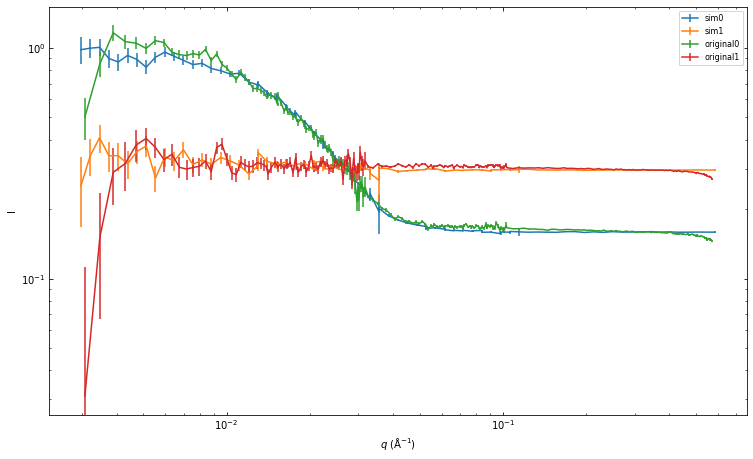

In [8]:
import pandas

fig, ax = plt.subplots()

original0 = pandas.read_csv('bu/sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata0 = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
original1 = pandas.read_csv('bu/sim1.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata1 = pandas.read_csv('sim1.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.errorbar(simdata0['Q'], simdata0['I'], simdata0['dI'], label="sim0")
ax.errorbar(simdata1['Q'], simdata1['I'], simdata1['dI'], label="sim1")
ax.errorbar(original0['Q'], original0['I'], original0['dI'], label="original0")
ax.errorbar(original1['Q'], original1['I'], original1['dI'], label="original1")

ax.legend(fontsize=8)
ax.set_ylabel("I", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
#ax.set_ylim(1e-2, 1e8)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()


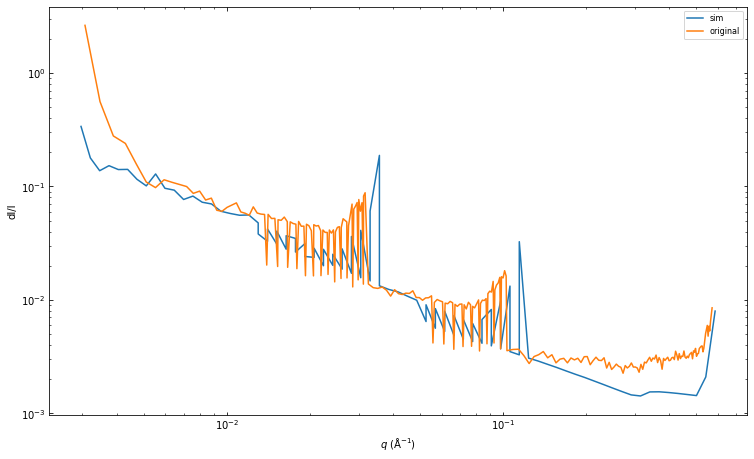

In [9]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim1.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim1.dat', sep=' ', skip_blank_lines=True,comment='#')

ax.plot(simdata['Q'], (simdata['dI']/simdata['I']), label="sim")
ax.plot(original['Q'], (original['dI']/original['I']), label="original")

ax.legend(fontsize=8)
ax.set_ylabel("dI/I", fontsize=10)
ax.set_yscale('log')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
#ax.set_ylim(0, 0.25)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()


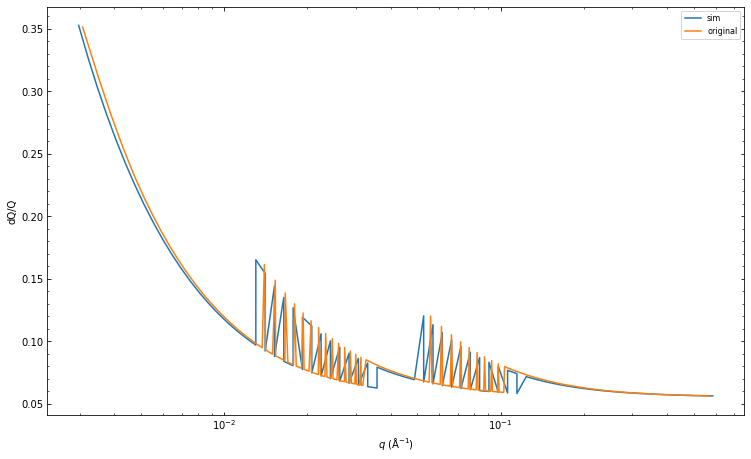

In [10]:
fig, ax = plt.subplots()

#i = 0
#while os.path.isfile('testdata.DAT'):
original = pandas.read_csv('bu/sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
simdata = pandas.read_csv('sim0.dat', sep=' ', skip_blank_lines=True,comment='#')
ax.plot(simdata['Q'], (simdata['dQ']/simdata['Q']), label="sim")
ax.plot(original['Q'], (original['dQ']/original['Q']), label="original")

ax.legend(fontsize=8)
ax.set_ylabel("dQ/Q", fontsize=10)
ax.set_yscale('linear')
ax.set_xscale('log')
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
#ax.set_ylim(0, 0.01)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()


# Experimental Optimization

* Entropypar.dat contains a list of all fit parameters with a designation, whether they are marginal (d) or nuisance (i) parameters. This is followed by the parameter name, the initial parameter value, and the fit boundaries.
* Configuration parameters are given by a preceeding n x y, where x is the data set it applies to and y the configuration number. Specifying x,y = '*' makes this parameter apply to all configurations.
* Any numbers x y following a fit parameter indicates that this paramter is used for this particular dataset/configuration to determine the background (incoherent crosssection). This typically applies to SLDs. The 'mode' argument for entropy.Entropy() then determines whether this is to be interpreted as an aqueous solvent or other. Sometimes, instead of subtracting an incoherent crosssection from the data, a background parameter is retained in the model. If any of the parameters is asigned an x = bi, this background will be se to the incoherent (isotropic) crosssection of the ith data set, instead of applying this value to the configuration. Fit boundaries for such backgrounds must be large enough to encompass all possible outcomes. They will not be updated dynamically.
* If three more numbers are given, this designates that an information content search over this parameter is performed (start, stop, step).
* A preceding f (fi or fd) at the beginning of the line indicates that the fit boundaries for such a search parameter are fixed (for example for volume fractions between 0 and 1), otherwise the fit boundary moves according to the varied parameter and the initally given fit boundaries.
* Any theta offset currently needs to have an initial value of zero. Otherwise, refl1d will shift the q-values during data simulation with unexpected outcomes.
* If an instrumental parameter is specified for one data set, the instrumental parameter needs to be specified for all other datasets, as well.
* Data filenames are currently limited to sim.dat for a single file fit, or simx.dat, x = 0 ... n, for fits with multiple data sets

In [11]:
text = [
        'i b0 * background0 0.509283 0.0 2.0',
        'i b1 * background1 0.295525 0.0 2.0',
        'i 0 * sld_solvent0 2.0 1.98 2.02 1.5 4.5 0.1',
        'i 1 * sld_solvent1 2.0 1.98 2.02 1.5 4.5 0.1',
        'i _ _ scale 0.0013 0.0001 0.005',
        'd _ _ sld  3.1 1.0 4.0',
        'i _ _ radius  65 40 90',
        'i _ _ radius_pd  0.3 0.1 0.5',
        'n * * lambda 6.00',
        'n * * differential_cross_section_buffer 0.0',
        'n * 0 sample_detector_distance 100',
        'n * 1 sample_detector_distance 400',
        'n * 2 sample_detector_distance 1300',
        'n * 0 source_sample_distance 387.6',
        'n * 1 source_sample_distance 850.05',
        'n * 2 source_sample_distance 1467',
        'n * 0 neutron_flux 9e5',
        'n * 1 neutron_flux 2e5',
        'n * 2 neutron_flux 8e4',
        'n * * source_aperture_radius 2.54',
        'n * * sample_aperture_radius 0.635',
        'n * * dlambda_lambda 0.136',
        'n * 0 beamstop_diameter 10.16',
        'n * 1 beamstop_diameter 10.16',
        'n * 2 beamstop_diameter 7.62',
        'n * 0 time 1200 0 0 0 7200 400',
        'n * 1 time 2400 0 0 1200 7200 400',
        'n * 2 time 3600 0 0 400 7200 400',
        'n * 0 beam_center_x 25.',
        'n * * cuvette_thickness 0.1'
        ]

f=open('entropypar.dat', 'w')
f.writelines(line + '\n' for line in text)
f.close()

In [12]:
# general fit setup
setupdir = setupdir
runfile = runfile
store = 'T'
fitsource = fitsource

# isotropic scattering background
# user-defined linear relationship between a SLD of the bulk solvent and the differential macroscopic scattering crosssection of the buffer
cross_section_background = {'slope':-0.1626, 'y_intercept': 0.7980}
mode = 'SANS_linear'

# particular entropy setup
burn = 5000
steps = 500
convergence = 2.0
miniter = 3
bClusterMode = False
bFetchMode = False
time = 2
bcalcsymmetric = True
upper_info_plotlevel = None
plotlimits_filename = ""
calcsingle = False

# setup batchscript for SLURM (if used)
script = ['#!/bin/bash\n',
          '#SBATCH --job-name=entro {mcmc_iteration}\n',
          '#SBATCH -A mc4s9np\n', '#SBATCH -p RM\n',
          '#SBATCH -t 0' + str(time) + ':00:00\n',
          '#SBATCH -N 4\n', '#SBATCH --ntasks-per-node 28\n',
          '\n',
          'set +x\n',
          'cd $SLURM_SUBMIT_DIR\n',
          '\n',
          'module load python/2.7.11_gcc\n',
          'export PYTHONPATH=/home/hoogerhe/bin/lib/python2.7/site-packages:/home/hoogerhe/src/bumps\n',
          '\n',
          'mpirun -np 112 python /home/hoogerhe/src/refl1d/bin/refl1d_cli.py {mcmc_dirname}/run.py --fit=dream --mpi --init=lhs --batch --pop=28 --time='
          + str(float(time) - 0.1) + ' --thin=20 --store={mcmc_dirname}/save --burn=' + str(burn)
          + ' --steps=' + str(steps) + '\n'
          ]
# script.append('cd '+dirname+'\n')


In [13]:
entr = entropy.Entropy(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    mcmcburn=burn,
    mcmcsteps=steps,
    convergence=convergence,
    miniter=miniter,
    mode=mode,
    background_rule = cross_section_background,
    bClusterMode=bClusterMode,
    bFetchMode=bFetchMode,
    calc_symmetric=bcalcsymmetric,
    upper_info_plotlevel=upper_info_plotlevel,
    plotlimits_filename=plotlimits_filename,
    slurmscript=script,
    configuration = configuration
)

The optimization might be supplemented with qmin, qmax, and qrangefromfile attributes that are applied to all datasets. These are independent of qrange limitations imparted by individual SANS configurations. When the q-range is taken from file, the first dataset (0) will be used. In most cases, provide the default values given below.

In [14]:
qmin = 0.001
qmax = 0.8
qrangefromfile = False
t_total = 7200 * 2

if RunOptimization:
    entr.run_optimization(qmin=qmin, qmax=qmax, qrangefromfile=qrangefromfile, t_total=t_total, optimizer='gpCAM', jupyter_clear_output=True, gpcam_iterations=100, retrain_async_at=[15, 30, 60])

/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/frank/opt/anaconda3/envs/Python37/lib/python3.7/site-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


In [15]:
entr.run_optimization(qmin=qmin, qmax=qmax, qrangefromfile=qrangefromfile, t_total=t_total, optimizer='gpcam', gpcam_iterations=0, jupyter_clear_output=True)

length of the dataset:  100
